# Astronomy 499: Assignment 3

In [22]:
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.units import cds
cds.enable()
import pandas as pd

## Part 1: Refraction Calculation

### 1a: Determine Necessary Equations

Read the Stone 1996 paper and determine which equations are needed.

In [26]:
latitude = -30.24463 * u.deg
longitude = -70.74942 * u.deg
altitude = 2647 * u.m
p0 = 101325 * u.Pa # sea level air presssure
g = const.g * (u.m/u.s**2)
R0 = 8.31447 * u.J/(u.mol*u.K) # gas constant
T0 = 19. * u.deg_C # typical sea level temperature
lapseRate = -6.5 * (u.deg_C/u.km) # typical rate of change of temperature with altitude
M = 0.0289644 * (u.kg/u.mol) # molar mass of dry air
humidity = 40. # typical humidity at many ovservatory sites


In [27]:
temperature = T0 + (lapseRate * altitude)
temperatureK = temperature.to(u.K, equivalencies = u.temperature())

pressure = (p0 * np.exp((-g * M * altitude) / (R0 * temperatureK))).to(u.Pa)
print(pressure.to(u.cds.mbar))


729.253598013056 mbar


## 1b: 

Write python functions for calculating each of the quantities needed for calculating refraction. In general, try to write a separate function for each numbered equation in the 1996 paper.

In [28]:
# Equations from 1996 paper

# calculating the water-vapor pressure (mm)
def power_vapor_pressure(temp, RH):
    t = temp.value
    x = np.log(RH/100)
    tdC_numerator = (((t + 238.3)*x) + (17.2694 * t))
    tdC_demoninator = ((t + 238.3) * (17.2694 - x)) - (17.2694 * t)
    tdC = (238.3 * (tdC_numerator/tdC_demoninator)) * u.deg_C
    t_dewpoint_C = tdC.value
    pressure = (4.50874 + (0.341724 * t_dewpoint_C) + (0.0106778 * t_dewpoint_C**2) + (0.184889e-3 * t_dewpoint_C**3) + (0.238294e-5 * t_dewpoint_C**4) + (0.203447e-7 * t_dewpoint_C**5)) * u.cds.mmHg
    return pressure

p_w = (power_vapor_pressure(temperature, humidity)).to(u.cds.mbar)
p_s = pressure.to(u.cds.mbar)

print(f"The water-vapor pressure is {p_w:.2f}.")
print(f"The dry air pressure is {p_s:.2f}.")

The water-vapor pressure is 2.57 mbar.
The dry air pressure is 729.25 mbar.


In [43]:
# Variable Definitions
# n = index of refraction
# n0 = index of air at the observing site
# p = density of air at Earth's surface
# p0 = density of air at some altitude
# r0

# eq 4, 9, 10, 14, 15, 16, 18, 20, 21 + 2, 5

def indexofrefraction(wavelength, Ps_in, Tinitial, Pw_in):
    T = 273.15 + Tinitial.value
    Ps = 1.333224 * (Ps_in.value - Pw_in.value)
    Pw = 1.333224 * Pw_in.value
    sigma = 1e4/(wavelength.to(u.um).value)
    Ds = (1 + (Ps * (57.90e-8 - (9.3250e-4/T) + (0.25844/T**2)))) * (Ps/T)
    Dw = (1 + Pw * (1 + 3.7e-4 * Pw) * (-2.37321e-3 + ((2.23366/T)-(710.792/T**2) + (7.75141e4/T**3)))) * (Pw/T)
    term_one = (2371.34 + (683939.7/(130 - sigma**2)) + (4547.3/(38.9 - sigma**2))) * Ds
    term_two = ((6487.31 + (58.058 * sigma**2) - (0.71150 * sigma**4) + (0.08851 * sigma**6))) * Dw
    n = ((term_one + term_two) / (1e8))
    return n

def calc_gamma(wavelength, Ps_in, Tinitial, Pw_in):
    n0 = indexofrefraction(wavelength, Ps_in, Tinitial, Pw_in) * (p0/p)
    gamma = n0 - 1
    return gamma

def calc_beta(tin): # eq 9
    t = tin.value
    beta = 0.001254 * ((273.15 + t)/273.15)
    return beta

def calc_kappa(phi_degrees, height): # 10
    phi = phi_degrees.to(u.rad).value
    h = height.value
    kappa = 1 + (0.005302 * (np.sin(phi)**2)) - (0.00000583 * (np.sin(2 * phi)**2)) - (0.000000315 * h)
    return kappa
    
# Atmospheric refraction
def atm_refraction(wavelength, Ps_in, Tinitial, Pw_in, phi, h, z0):
    n0 = indexofrefraction(wavelength, Ps_in, Tinitial, Pw_in) * (p0/pressure)
    gamma = n0 - 1
    beta = calc_beta(Tinitial)
    kappa = calc_kappa(phi , h)
    refraction = (kappa * gamma * (1 - beta) * np.tan(z0)) - (kappa * gamma * (beta - (gamma / 2)) * (np.tan(z0)**3))
    return refraction
    
    

## Part 2: Applying the Refraction Calculation

### 2a: Total Refraction vs. Wavelength

Use the parameters and plot total refraction as a function of wavelength for a moderate zenith angle (30 degrees) from 300 nm - 1000 nm.

In [40]:
# g-band
gband = pd.read_csv('/Users/audrey/Desktop/throughputs-master/baseline/total_g.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
gband_wavelength = np.array(gband[0]) * u.nm
gband_throughput = np.array(gband[1])
print(gband_throughput.max())

# i-band
iband = pd.read_csv('/Users/audrey/Desktop/throughputs-master/baseline/total_i.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
iband_wavelength = np.array(iband[0]) * u.nm
iband_throughput = np.array(iband[1])


0.4125201818071813


In [48]:
wavelength_values = np.linspace(300, 1000, 100) * u.nm
zin = 30 * u.deg

refraction = atm_refraction(500*u.nm, p_s, temperature, p_w, latitude, altitude, zin)

print(refraction)

9.279845663837895e+28


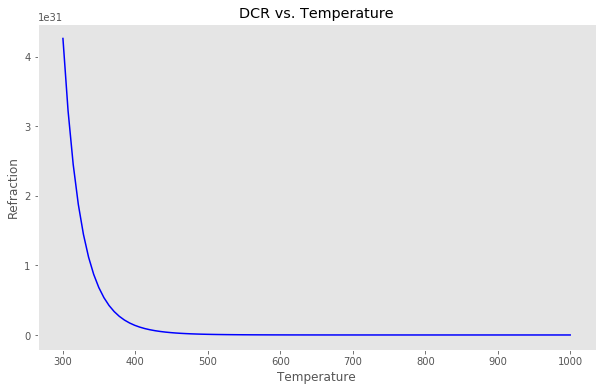

In [42]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(wavelength_values, refraction, color = 'b')
ax.set_title('DCR vs. Temperature')
ax.set_xlabel('Temperature')
ax.set_ylabel('Refraction');
ax.grid()

### 2b: 

Use the g- and i-band filter throughputs to calculate maximum DCR within g- and i-bands and plot each as a function of zenith angle from 0 to 65 degrees zenith angle.

In [33]:
zenith_angle = np.linspace(0, 65, 66)

# For G-Band
maxthroughput_gband = gband_throughput.max()
maxwave_index_g = np.where(gband_throughput == maxthroughput_gband)
print(maxwave_index_g)
maxwavelength_gband = gband_wavelength[maxwave_index_g]
#maxwavelength_gband = gband_wavelength[2372]

gwavelength_range = np.where(gband_throughput == maxthroughput_gband/2)
print(gwavelength_range)

# For I-Band
maxthroughput_iband =iband_throughput.max()
maxwave_index_i = np.where(iband_throughput == maxthroughput_iband)
maxwavelength_iband = iband_wavelength[maxwave_index_i]
#maxwavelength_iband = gband_wavelength[4120]

iwavelength_range = np.where(iband_throughput == maxthroughput_iband/2)
print(iwavelength_range)


(array([2372]),)
(array([], dtype=int64),)
(array([], dtype=int64),)


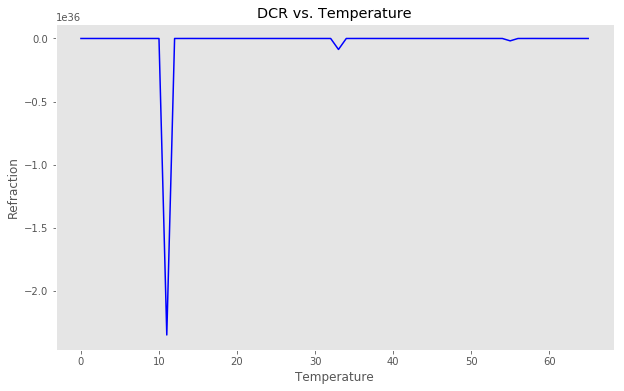

In [44]:
# Max Refraction for G-Band

refraction_gband = atm_refraction(maxwavelength_gband, p_s, temperature, p_w, latitude, altitude, zenith_angle)

# Plot for g-band
fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(zenith_angle, refraction_gband, color = 'b')
ax.set_title('DCR vs. Temperature')
ax.set_xlabel('Temperature')
ax.set_ylabel('Refraction');
ax.grid()


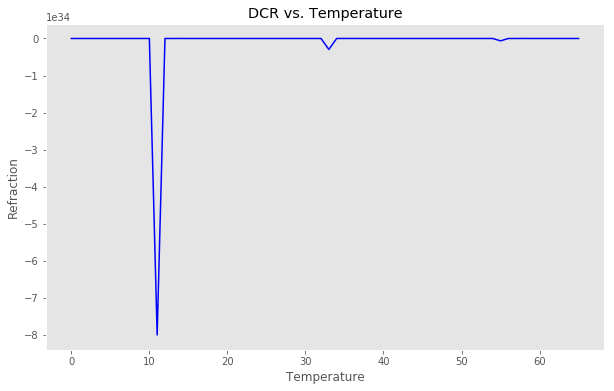

In [45]:
# Max Refraction for I-Band

refraction_iband = atm_refraction(maxwavelength_iband, p_s, temperature, p_w, latitude, altitude, zenith_angle)

# Plot for i-band
fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(zenith_angle, refraction_iband, color = 'b')
ax.set_title('DCR vs. Temperature')
ax.set_xlabel('Temperature')
ax.set_ylabel('Refraction');
ax.grid()


## Part 3: Explore the Parameter Space Further

### 3a: DCR vs. Temperature

Using the g-band minimum and maximum wavelengths and a 30 degree zenith angle, plot DCR as a function of temperature.

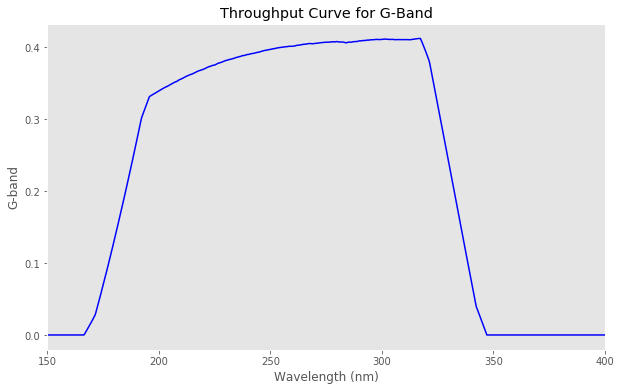

In [21]:
# From Assignment #2

column_names = ['Wave', 'FluxD', 'e_FluxD', 'None1', 'None2', 'None3', 'None4', 'None5', 'None6', 'None7', 'None8']
simulatedquasarspectrum = pd.read_csv('/Users/audrey/Desktop/Vanden_Berk_quasars.txt', delimiter = " ", header=None, skipinitialspace = True, names = column_names)
subsection = simulatedquasarspectrum[23:]
subsection = simulatedquasarspectrum.apply(pd.to_numeric, errors='coerce')
data = subsection[['Wave', 'FluxD', 'e_FluxD']]

# Wavelength
wavelength_or = np.array(subsection['Wave']) * u.Angstrom
wavelength_nm = (wavelength_or[23:]).to(u.nm)

# Relative Flux Density
relative_fluxdensity = subsection['FluxD'][23:]

# G-Band
fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(wavelength_nm, gband_throughput[0:7755],
        color = 'b')
ax.set_title('Throughput Curve for G-Band')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('G-band');
ax.set_xlim(150,400)
ax.grid()

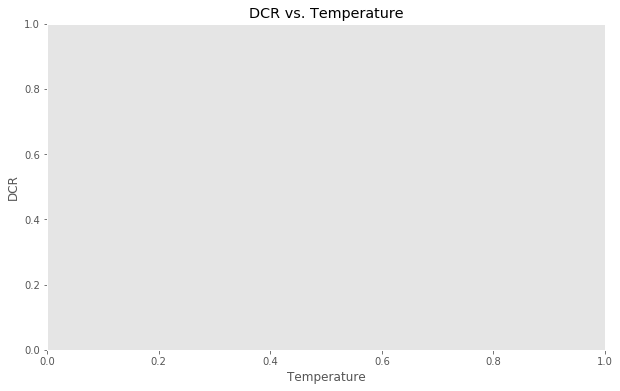

In [78]:
# Define zenith angle
z30 = 30 * u.deg

# Define temperature range
temp = np.linspace(0, 300, 301) * u.K

# G-Band min and max wavelengths
gwavelengths = np.linspace()* u.nm

# Refraction
refraction_gband = atm_refraction(gwavelengths, p_s, temperature, p_w, temperatureK, latitude, altitude, z30)

fig, ax = plt.subplots(1, 1, figsize = (10,6))
#plt.plot(temperature, dcr, color = 'b')
ax.set_title('DCR vs. Temperature')
ax.set_xlabel('Temperature')
ax.set_ylabel('DCR');
ax.grid()

### 3b: DCR vs. Pressure

Plot DCR as a function of pressure.

In [ ]:
# Pressure range
press_range = np.linspace()

fig, ax = plt.subplots(1, 1, figsize = (10,6))
#plt.plot(pressure, dcr, color = 'b')
ax.set_title('DCR vs. Pressure')
ax.set_xlabel('Pressure')
ax.set_ylabel('DCR');
ax.grid()

### 3c: DCR vs. Humidity

Plot DCR as a function of humidity.

In [20]:
# Humidity range
hum_range = np.linspace(0, 1.0, 100)

pressure_humiditychange = 

# Refraction based on humidity
refraction_gband = atm_refraction(maxwavelength_gband, p_s, temperature, p_w, temperatureK, latitude, altitude, zenith_angle)

fig, ax = plt.subplots(1, 1, figsize = (10,6))
#plt.plot(humidity, dcr, color = 'b')
ax.set_title('DCR vs. Humidity')
ax.set_xlabel('Humidity')
ax.set_ylabel('DCR');
ax.grid()

SyntaxError: invalid syntax (<ipython-input-20-a06e1a846bed>, line 4)